# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [152]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [153]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [154]:
def P1(num_examples=5):
    for i in range(num_examples):
        print('------------------------------------')
        print(train_data[i])
        print('------------------------------------')
        print('LABEL', newsgroups_train.target_names[train_labels[i]])
        print('------------------------------------')

    
P1(5)

------------------------------------
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
------------------------------------
LABEL comp.graphics
------------------------------------
------------------------------------


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jone

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [155]:
def P2():
    vectorizer = CountVectorizer()
    data_fit = vectorizer.fit_transform(train_data)
    print('The vocabulary size is', len(vectorizer.vocabulary_))
    doc_array = data_fit.toarray()
    # each entry in the array represents a document and is an array
    print('There are', len(doc_array), 'documents.')
    # each entry in the document array is a frequency of a particular term
    print('There are', len(doc_array[0]), 'terms represented in the set of documents.')
    print('Another way of getting these counts:', data_fit.shape)
    
    non_zero_count = [len(doc[doc>0]) for doc in doc_array]
    print('Average terms per document is', sum(non_zero_count)/len(non_zero_count))

    print('The fraction of the non-zero entries in the matrix is', \
          float(data_fit.nnz) / (data_fit.shape[0] * data_fit.shape[1]))

    terms = vectorizer.get_feature_names()
    print('The first term (alphabetically) is', terms[0])
    print('The last term (alphabetically) is', terms[-1])

    # transform the training data into a matrix of word unigram feature vectors 
    # using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"]
    vocab = ["atheism", "graphics", "space", "religion"]
    short_vectorizer = CountVectorizer(vocabulary=vocab)
    print('The short vocabulary size is', len(short_vectorizer.get_feature_names()))
    doc_array = short_vectorizer.transform(train_data).toarray()
    non_zero_count = [len(doc[doc>0]) for doc in doc_array]
    print('With short vocabulary, average terms per document is', sum(non_zero_count)/len(non_zero_count))
    
    # transform the training data into a matrix of character bigram and trigram feature vectors
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,3))
    data_fit = vectorizer.fit_transform(train_data)
    terms = vectorizer.get_feature_names()
    print('The size of the bigram/trigram vocabulary is', len(terms))
    
    # transform the training data into a matrix of word unigram feature vectors 
    # and prune words that appear in fewer than 10 documents. 
    vectorizer = CountVectorizer(min_df=10)
    data_fit = vectorizer.fit_transform(train_data)
    terms = vectorizer.get_feature_names()
    print('The size of the pruned vocabulary is', len(terms))

    # transform the training data into a matrix of word unigram feature vectors
    vectorizer = CountVectorizer()
    vectorizer.fit_transform(train_data)
    train_terms = vectorizer.get_feature_names()
    vectorizer = CountVectorizer()
    vectorizer.fit_transform(dev_data)
    dev_terms = vectorizer.get_feature_names()
    dev_not_in_train = len(set(dev_terms) - set(train_terms))
    print('The fraction of words in the development vocabulary that are missing from the training vocabulary', \
         dev_not_in_train/len(dev_terms))
    
    
P2()

The vocabulary size is 26879
There are 2034 documents.
There are 26879 terms represented in the set of documents.
Another way of getting these counts: (2034, 26879)
Average terms per document is 96.70599803343165
The fraction of the non-zero entries in the matrix is 0.0035978272269590263
The first term (alphabetically) is 00
The last term (alphabetically) is zyxel
The short vocabulary size is 4
With short vocabulary, average terms per document is 0.26843657817109146
The size of the bigram/trigram vocabulary is 510583
The size of the pruned vocabulary is 3064
The fraction of words in the development vocabulary that are missing from the training vocabulary 0.24787640034470024


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [156]:
def knn(train_data, train_labels, dev_data, dev_labels, k=1):
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(train_data, train_labels)
    predicted_labels = model.predict(dev_data)
    f1 = f1_score(dev_labels, predicted_labels, average='weighted')
    print(f'k={k}, f1={f1}')

    
def mnb(train_data, train_labels, dev_data, dev_labels, a=1.0):
    model = MultinomialNB(alpha=a)
    model.fit(train_data, train_labels)
    predicted_labels = model.predict(dev_data)
    f1 = f1_score(dev_labels, predicted_labels, average='weighted')
    print(f'alpha={a}, f1={f1}')


def lr(train_data, train_labels, dev_data, dev_labels, c=1.0):
    model = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
    model.fit(train_data, train_labels)
    predicted_labels = model.predict(dev_data)
    f1 = f1_score(dev_labels, predicted_labels, average='weighted')
    # model.coef_ is a 4 (labels) by (# of terms/features) matrix
    # going to calculate the sum of the squares of the weights in each row
    sums_of_squares = []
    for label_weights in model.coef_:
        squares = label_weights * label_weights
        sums_of_squares.append(sum(squares))
    print(f'C={c}, f1={f1}')
    print(f'sums of squares of weights for 4 labels={sums_of_squares}')
    
    
    
def P3():
    # Transform the training and development data to matrices of word unigram feature vectors.
    trn_vectorizer = CountVectorizer()
    trn_fit = trn_vectorizer.fit_transform(train_data)
    trn_doc_array = trn_fit.toarray()
    trn_terms = trn_vectorizer.get_feature_names()
    dev_vectorizer = CountVectorizer(vocabulary=trn_terms)
    dev_fit = dev_vectorizer.fit_transform(dev_data)
    dev_doc_array = dev_fit.toarray()
    # each row in the doc arrays represents a document and is an array of term frequency counts
    
    # 1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score. 
    # For each model, show the k value and f1 score.
    print('k nearest neighbors')
    knn(trn_doc_array, train_labels, dev_doc_array, dev_labels, 1)
    knn(trn_doc_array, train_labels, dev_doc_array, dev_labels, 3)
    knn(trn_doc_array, train_labels, dev_doc_array, dev_labels, 5)
    knn(trn_doc_array, train_labels, dev_doc_array, dev_labels, 7) # k=7 has the best f1 score
    knn(trn_doc_array, train_labels, dev_doc_array, dev_labels, 9)
    knn(trn_doc_array, train_labels, dev_doc_array, dev_labels, 11)
    print()

    # 2. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately 
    # to optimize f1 score. For each model, show the alpha value and f1 score.
    print('multinomial naive Bayes')
    mnb(trn_doc_array, train_labels, dev_doc_array, dev_labels, 1.0e-10)
    mnb(trn_doc_array, train_labels, dev_doc_array, dev_labels, 0.0001)
    mnb(trn_doc_array, train_labels, dev_doc_array, dev_labels, 0.001)
    mnb(trn_doc_array, train_labels, dev_doc_array, dev_labels, 0.01)
    mnb(trn_doc_array, train_labels, dev_doc_array, dev_labels, 0.1) # alpha=0.1 has the best f1 score
    mnb(trn_doc_array, train_labels, dev_doc_array, dev_labels, 0.5)
    mnb(trn_doc_array, train_labels, dev_doc_array, dev_labels, 1.0)
    mnb(trn_doc_array, train_labels, dev_doc_array, dev_labels, 2.0)
    mnb(trn_doc_array, train_labels, dev_doc_array, dev_labels, 10.0)
    print()
    
    # 3. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C 
    # set approximately to optimize f1 score. For each model, show the C value, f1 score, and sum of squared 
    # weights for each topic.    
    print('logistic regression')
    lr(trn_doc_array, train_labels, dev_doc_array, dev_labels, 10.0)
    lr(trn_doc_array, train_labels, dev_doc_array, dev_labels, 2.0)
    lr(trn_doc_array, train_labels, dev_doc_array, dev_labels, 1.0)
    lr(trn_doc_array, train_labels, dev_doc_array, dev_labels, 0.5) # C=0.5 has the best f1 score
    lr(trn_doc_array, train_labels, dev_doc_array, dev_labels, 0.1)
    lr(trn_doc_array, train_labels, dev_doc_array, dev_labels, 0.01)
    lr(trn_doc_array, train_labels, dev_doc_array, dev_labels, 0.001)
    lr(trn_doc_array, train_labels, dev_doc_array, dev_labels, 0.0001)
    lr(trn_doc_array, train_labels, dev_doc_array, dev_labels, 1.0e-10)

    
P3()

k nearest neighbors
k=1, f1=0.39471048126424524
k=3, f1=0.4230384271439681
k=5, f1=0.44283938039620135
k=7, f1=0.46603879404544657
k=9, f1=0.45574370029982564
k=11, f1=0.434233473713461

multinomial naive Bayes
alpha=1e-10, f1=0.747240657284563
alpha=0.0001, f1=0.7628348704826354
alpha=0.001, f1=0.7702518836155706
alpha=0.01, f1=0.7751663218544357
alpha=0.1, f1=0.7903052385098862
alpha=0.5, f1=0.7862862961995258
alpha=1.0, f1=0.7777320236017224
alpha=2.0, f1=0.7689966472342658
alpha=10.0, f1=0.6674814338256576

logistic regression
C=10.0, f1=0.6865669233056786
sums of squares of weights for 4 labels=[585.9315002800115, 448.0637756267944, 539.505905695216, 530.8639414447797]
C=2.0, f1=0.6924826561168351
sums of squares of weights for 4 labels=[257.56044291228454, 197.89425746726914, 239.77582317384676, 226.60557338318557]
C=1.0, f1=0.6944172871853819
sums of squares of weights for 4 labels=[166.9673478302272, 130.92765037130744, 157.96075381943743, 145.75901208046295]
C=0.5, f1=0.708473

ANSWERS:

*4. Why doesn't k-Nearest Neighbors work well for this problem?*

I think it is because the vectors are so long and sparse. Documents with the same label could be far from each other if they just share a few representative terms in common, and a document with a different label could be closer because it shares more general terms.

*5. Why doesn't Logistic Regression work as well as Naive Bayes does?*

My guess is that it is because Logistic Regression is still a linear model that has to compute a coefficient for each term. Small non-zero coefficients for several terms will add up and cause the output probability to be higher. Also, having two occurrences of a term will add the coefficent twice. There may not be a linear relationship like this in the training data. Naive Bayes multiplies the observed probabilities of each term with the probability of each term given each of the classes. No linear relationship is assumed.

*6. What is the relationship between logistic regression's sum of squared weights vs. C value?*

The smaller the C value (inverse of lambda), the greater the penalty for a large weight, so as C gets smaller, so does the magnitude of the weights.

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [157]:
def P4():
    # Transform the data to a matrix of word bigram feature vectors. 
    # (You can use CountVectorizer and its .fit_transform method to transform data.)
    trn_vectorizer = CountVectorizer(ngram_range=(2,2))
    trn_fit = trn_vectorizer.fit_transform(train_data)
    trn_doc_array = trn_fit.toarray()
    trn_terms = trn_vectorizer.get_feature_names()
    
    # Produce a Logistic Regression model. (Train on the transformed training data.)
    # (You can use LogisticRegression(C=0.5, solver="liblinear", multi_class="auto"))
    model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    model.fit(trn_doc_array, train_labels)
    
    # For each topic, find the 5 features with the largest weights (that's 20 features in total). 
    # (You can use LogisticRegression's .coef_ method to get weights for each topic.)
    # (You can use np.argsort to get indices sorted by element value.)
    # coef_ is an ndarray of shape #topics by #bigrams
    topic_top5 = []
    for i in range(4):
        # topic i top 5 weight indices
        topic_top5.append(np.argsort(abs(model.coef_[i,:]))[-5:])

    # (Show a 20 row (features) x 4 column (topics) table of the weights.)
    print('bigram          topic 0  topic 1  topic 2  topic 3 ')
    print('=============== ======== ======== ======== ========')
    for top5_wt in topic_top5: 
        for wt_ind in top5_wt:
            row = model.coef_[:, wt_ind]
            print(f'{trn_terms[wt_ind]:15} {row[0]:8.5f} {row[1]:8.5f} {row[2]:8.5f} {row[3]:8.5f}')
        print('===================================================')

P4()

bigram          topic 0  topic 1  topic 2  topic 3 
=============== ======== ======== ======== ========
you are          0.47274 -0.27991 -0.48145  0.02836
was just         0.48205 -0.13142 -0.12886 -0.22747
cheers kent      0.55572 -0.69790 -0.66379  0.53481
claim that       0.60555 -0.19904 -0.27439 -0.14037
looking for     -0.63034  1.10837 -0.49993 -0.57186
is there        -0.34088  0.75498 -0.46825 -0.25708
out there       -0.27480  0.75868 -0.47902 -0.27709
comp graphics   -0.29217  0.80120 -0.37090 -0.28518
in advance      -0.45935  0.83257 -0.43849 -0.41845
looking for     -0.63034  1.10837 -0.49993 -0.57186
and such        -0.20427 -0.33752  0.59056 -0.21820
sci space       -0.25801 -0.32915  0.62112 -0.22125
cheers kent      0.55572 -0.69790 -0.66379  0.53481
the moon        -0.35056 -0.49272  0.83122 -0.21379
the space       -0.26819 -0.53009  0.87115 -0.27384
ignorance is    -0.15801 -0.17107 -0.13958  0.50431
does anyone     -0.37977  0.43286  0.03561 -0.51641
cheers kent 

*Do you see any surprising features in this table?*

ANSWER: Yes, many of the top 5 bigrams are shared by one or more topics. They sometimes have an opposite sign in the other topic(s), but not always. Also, some of the top 5 bigrams don't seem to have much content, such as "you are", "was just", "and such", and "does anyone". Maybe this is due to too small a sample size. Also, some of the coefficients in the top 5 are negative, meaning having that bigram would greatly reduce the probability of being from that particular category.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [165]:
def no_preprocessor(s):
    return s


def better_preprocessor(s):
    # transforming strings to lower case
    s = s.lower() # alone, improved f1 by 0.055633
    
    # replacing sequences of numbers with single tokens, 
    # s = re.sub(r'\d{5,}', 'LONGNUM', s) # alone, improved f1 by 0.000307
    # did not improve f1: s = re.sub(r'\d{4,4}', '4DIGITS', s)
    s = re.sub(r'\d+', 'NUM', s) # alone, improved f1 by 0.000138, but not with LONGNUM above
    
    # removing various non-letter characters
    # did not improve f1: 
    # s = re.sub(r'[^a-z]+', ' ', s)
    # did not improve f1:
    # s = s.replace("_", " ")
    s = s.replace('"', " ") # alone, improved f1 by 0.05407 but had no effect with lower
    s = s.replace("*", " ")
    s = s.replace("'", " ")
    s = s.replace("(", " ")
    s = s.replace(")", " ")
    # did not improve f1:
    # s = s.replace('-','')
    # did not improve f1:
    # s = s.replace(".", "")
    # did not improve f1:
    # s = s.replace(",", "") # alone, improved f1 by 0.050959 but with lower decreased the f1 score
    
    # shortening long words
    # tried various lengths, none improved f1
    # s = s[:7]
    return s.strip()
    
    
def P5():
    # Produce a Logistic Regression model (with no preprocessing of text).
    # (You can use LogisticRegression(C=0.5, solver="liblinear", multi_class="auto") to produce a logistic regression model.)
    trn_vectorizer_npp = CountVectorizer(preprocessor=no_preprocessor)
    trn_fit_npp = trn_vectorizer_npp.fit_transform(train_data)
    trn_doc_array_npp = trn_fit_npp.toarray()
    model_npp = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    model_npp.fit(trn_doc_array_npp, train_labels)
    trn_terms_npp = trn_vectorizer_npp.get_feature_names()

    # Evaluate and show its f1 score and size of the dictionary.
    # You can use metrics.f1_score(..., average="weighted") to compute f1 score.
    dev_vectorizer_npp = CountVectorizer(vocabulary=trn_terms_npp)
    dev_fit_npp = dev_vectorizer_npp.fit_transform(dev_data)
    dev_doc_array_npp = dev_fit_npp.toarray()
    predicted_labels_npp = model_npp.predict(dev_doc_array_npp)
    f1_npp = f1_score(dev_labels, predicted_labels_npp, average='weighted')
    print(f'no preprocessing: f1={f1_npp:.3}  dict. size={len(trn_terms_npp)}')
    
    # Produce an improved Logistic Regression model by preprocessing the text. 
    # (Train on the transformed training data.)
    # (You can use CountVectorizer(preprocessor=...) to preprocess strings with your own custom-defined function.)
    trn_vectorizer = CountVectorizer(preprocessor=better_preprocessor)
    # removing various non-letter characters
    trn_fit = trn_vectorizer.fit_transform(train_data)
    trn_doc_array = trn_fit.toarray()
    model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    model.fit(trn_doc_array, train_labels)
    trn_terms = trn_vectorizer.get_feature_names()
    # print(trn_terms)
    
    # Evaluate and show its f1 score and size of the vocabulary. 
    # (Evaluate on the transformed development data.)
    dev_vectorizer = CountVectorizer(preprocessor=better_preprocessor, vocabulary=trn_terms)
    # removing various non-letter characters
    dev_fit = dev_vectorizer.fit_transform(dev_data)
    dev_doc_array = dev_fit.toarray()
    predicted_labels = model.predict(dev_doc_array)
    f1 = f1_score(dev_labels, predicted_labels, average='weighted')
    print(f'with preprocessing: f1={f1:.3}  dict. size={len(trn_terms)}')
    
    # Try for an improvement in f1 score of at least 0.02.
    print(f'Improvement of f1 score: {f1-f1_npp:.5}')
    print(f'How much did the improved model reduce the vocabulary size? {len(trn_terms_npp)-len(trn_terms)}')
    
    
P5()

no preprocessing: f1=0.653  dict. size=33291
with preprocessing: f1=0.709  dict. size=24761
Improvement of f1 score: 0.055771
How much did the improved model reduce the vocabulary size? 8530


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

reg. strength:   500  vocab. size=18801  f1=0.699
reg. strength:   250  vocab. size=14232  f1=0.711
reg. strength:   200  vocab. size= 9352  f1=0.705
reg. strength:   150  vocab. size= 9624  f1=0.708
reg. strength:   100  vocab. size= 8160  f1=0.702
reg. strength:    60  vocab. size= 5599  f1=0.709
reg. strength:    55  vocab. size= 5509  f1=0.698
reg. strength:    50  vocab. size= 5233  f1=0.703
reg. strength:    45  vocab. size= 4949  f1=0.7
reg. strength:    40  vocab. size= 4684  f1=0.703
reg. strength:    35  vocab. size= 4479  f1=0.705
reg. strength:    30  vocab. size= 4186  f1=0.698
reg. strength:    25  vocab. size= 3779  f1=0.703
reg. strength:    20  vocab. size= 3452  f1=0.711
reg. strength:    15  vocab. size= 2972  f1=0.696
reg. strength:    10  vocab. size= 2949  f1=0.694
reg. strength:     5  vocab. size= 2307  f1=0.7
reg. strength:     1  vocab. size=  933  f1=0.695
reg. strength:   0.5  vocab. size=  658  f1=0.672
reg. strength:   0.1  vocab. size=  195  f1=0.704


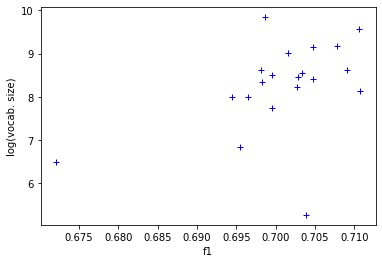

In [159]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    trn_vectorizer = CountVectorizer()
    trn_fit = trn_vectorizer.fit_transform(train_data)
    trn_doc_array = trn_fit.toarray()
    trn_terms = trn_vectorizer.get_feature_names()

    f1_vals = []
    log_vocab = []
    # For several L1 regularization strengths ...
    for strength in [500, 250, 200, 150, 100, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1, 0.5, 0.1]:
        # Produce a Logistic Regression model using the L1 regularization strength. 
        l1_model = LogisticRegression(C=strength, solver="liblinear", multi_class="auto", penalty="l1", tol=0.015)
        l1_model.fit(trn_doc_array, train_labels)

        # Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories. 
        new_trn_terms = []
        coef = l1_model.coef_
        for i in range(coef.shape[1]):
            if coef[0,i] > 0 or coef[1,i] > 0 or coef[2,i] > 0 or coef[3,i] > 0:
                new_trn_terms.append(trn_terms[i])

        # Produce a new Logistic Regression model using the reduced vocabulary and L2 regularization strength of 0.5. 
        new_trn_vectorizer = CountVectorizer(vocabulary=new_trn_terms)
        new_trn_fit = new_trn_vectorizer.fit_transform(train_data)
        new_trn_doc_array = new_trn_fit.toarray()
        l2_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", penalty="l2")
        l2_model.fit(new_trn_doc_array, train_labels)
        dev_vectorizer = CountVectorizer(vocabulary=new_trn_terms)
        dev_fit = dev_vectorizer.fit_transform(dev_data)
        dev_doc_array = dev_fit.toarray()
        predicted_labels = l2_model.predict(dev_doc_array)

        # Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
        f1 = f1_score(dev_labels, predicted_labels, average='weighted')
        print(f'reg. strength: {strength:5}  vocab. size={len(new_trn_terms):5}  f1={f1:.3}')
        f1_vals.append(f1)
        log_vocab.append(np.log(len(new_trn_terms)))
        
    # Show a plot of f1 score vs. log vocabulary size. 
    # Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
    plt.plot(f1_vals, log_vocab, 'b+')
    plt.xlabel('f1')
    plt.ylabel('log(vocab. size)')
    
P6()

*How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?*

ANSWER: It's an improvement. In part 5 above, using the full vocabulary, the f1 was 0.709, but using various regularization strengths with the l1 norm produced f1 values higher than that (0.711).

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [193]:
def P7():
    # Produce a Logistic Regression model based on data represented in tf-idf form, 
    #     with L2 regularization strength of 100. 
    trn_vectorizer = TfidfVectorizer()
    trn_fit = trn_vectorizer.fit_transform(train_data)
    trn_doc_array = trn_fit.toarray()
    trn_terms = trn_vectorizer.get_feature_names()
    model = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    model.fit(trn_doc_array, train_labels)
    
    # Evaluate and show the f1 score.
    dev_vectorizer = TfidfVectorizer(vocabulary=trn_terms)
    dev_fit = dev_vectorizer.fit_transform(dev_data)
    dev_doc_array = dev_fit.toarray()
    predicted_labels = model.predict(dev_doc_array)
    f1 = f1_score(dev_labels, predicted_labels, average='weighted')
    print(f'f1={f1:.3}')
    print()
    # looks like it did a little better than the C=100 regularization above
    
    # Show the 3 documents with highest R ratio, where ...
    # 𝑅𝑟𝑎𝑡𝑖𝑜 = 𝑚𝑎𝑥𝑖𝑚𝑢𝑚 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑 𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦 ÷ 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑 𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑙𝑎𝑏𝑒𝑙
    probs = model.predict_proba(dev_doc_array) # rows are documents, columns are topics
    r_ratio = []
    for (doc_prob, doc_label) in zip(probs, dev_labels):
        r_ratio.append(max(doc_prob)/doc_prob[doc_label])
    worst_3 = np.argsort(r_ratio)[-3:]
    for index in worst_3:
        print(f'document number: {index}')
        print(f'R-ratio: {r_ratio[index]}')
        print(f'predicted: {newsgroups_train.target_names[predicted_labels[index]]}')
        print(f'actual: {newsgroups_train.target_names[dev_labels[index]]}')
        print(f'document: {dev_data[index]}')
        print()
    
    mormon_ind = trn_terms.index('mormon')
    ftp_ind = trn_terms.index('ftp')
    print(f'mormon tf-idf: {dev_doc_array[665, mormon_ind]}')
    print(f'ftp tf-idf: {dev_doc_array[665, ftp_ind]}')
    coefs = model.coef_
    print('coefficients')
    print('topic   mormon   ftp')
    print(f'topic 0 {coefs[0,mormon_ind]:8.5f} {coefs[0,ftp_ind]:8.5f}')
    print(f'topic 1 {coefs[1,mormon_ind]:8.5f} {coefs[1,ftp_ind]:8.5f}')
    print(f'topic 2 {coefs[2,mormon_ind]:8.5f} {coefs[2,ftp_ind]:8.5f}')
    print(f'topic 3 {coefs[3,mormon_ind]:8.5f} {coefs[3,ftp_ind]:8.5f}')

P7()

f1=0.757

document number: 665
R-ratio: 358.76020794092364
predicted: comp.graphics
actual: talk.religion.misc
document: Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

document number: 607
R-ratio: 386.434281431301
predicted: talk.religion.misc
actual: alt.atheism
document: 
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


document number: 215
R-ratio: 1010.9206519404331
predicted: comp.graphics
actual: talk.religion.misc
document: I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have

*How is `TfidfVectorizer` different than `CountVectorizer`?*

ANSWER: For each document, `CountVectorizer` produces a vector where each entry corresponds to a term and is a count of how many times that term appears in the document. This is the term frequency (tf). If the words "and" and "vehicle" each appear three times, they will be counted equally. However, the word "and" will appear in almost every other document, while the word "vehicle" will only appear in certain documents. `TfidfVectorizer` tries to account for the ability of words to distinguish documents by essentially dividing the term frequency by the number of times the word appears in the entire collection of documents. This is the document frequency (df) and the tf is being divided by the df, so it is the inverse document frequency (idf). Therefore, in the example, the count for "and" would be divided by a very large number, making its contribution to the vector small. The count for "vehicle" would be divided by a much smaller number since that term appears less often in the collection of documents, making its contribution to the vector larger than the contribution of "and", despite the fact that each term appeared three times.

*Explain what the R ratio describes.*

ANSWER: It tells you how bad the prediction is. The lowest (and best) R can be is 1, meaning the probabilities of the prediction and the actual values are the same. But when R is much larger than 1, it indicates the model was quite certain that the correct category was incorrect.

*What kinds of mistakes is the model making?* 

ANSWER: I think it is picking up vocabulary that is very significant in the predicted topic but that is only represents a secondary focus of the article. For example, ftp, LaTeX and postscript could easily be used in an article about computer graphics but they are actually being used when describing a text on religion.

*Suggest a way to address one particular issue that you see.*

ANSWER: Somehow, we have to increase the effect of words that are very representative of the category over words in another category. For example, seeing "Mormon" should greatly increase the probability of one of the religion categories over the computer graphics category. Above, I looked at the tf-idf values for 'mormon' and 'ftp' in document 665 and found that 'mormon' does have a higher value. But when looking at the coefficients on 'mormon' and 'ftp' in the model, 'ftp' has a much higher value for its natural category than 'mormon' does for its category. Also, for 'mormon' the other categories have negative values that are small in magnitude while 'ftp' has greater magnitude negative values for its other categories. This gives 'ftp' a much greater pull towards the computer graphics category.

I wonder if using a Naive Bayes model would do better with this. Also, could the problem be with "Mormon", "Mormon's" and "Mormon"" being counted as different words, thereby weakening their influence? I would try the document preprocessing from above to try to collapse them into the same word. Similarly, performing stemming to include 'mormonism' and 'mormons' with 'mormon' could increase its influence. Also, maybe we need to allow higher weights on the coefficients, so using a larger C value might help.

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.

In [206]:
stemmer = nltk.stem.porter.PorterStemmer()

def stem_tok(text):
    return [stemmer.stem(word) for word in text.split()]
    
    
def P8():
    # the same code as P7 above, except using bigrams
#    trn_vectorizer = TfidfVectorizer(preprocessor=better_preprocessor, tokenizer=stem_tok, max_df=0.75)
    trn_vectorizer = TfidfVectorizer(preprocessor=better_preprocessor, max_df=0.85)
    trn_fit = trn_vectorizer.fit_transform(train_data)
    trn_doc_array = trn_fit.toarray()
    trn_terms = trn_vectorizer.get_feature_names()
    model = LogisticRegression(C=300, solver="liblinear", multi_class="auto")
#    model = MultinomialNB(alpha=0.1)
    model.fit(trn_doc_array, train_labels)
#    dev_vectorizer = TfidfVectorizer(preprocessor=better_preprocessor, tokenizer=stem_tok, max_df=0.25, vocabulary=trn_terms)
    dev_vectorizer = TfidfVectorizer(preprocessor=better_preprocessor, max_df=0.85, vocabulary=trn_terms)
    dev_fit = dev_vectorizer.fit_transform(dev_data)
    dev_doc_array = dev_fit.toarray()
    predicted_labels = model.predict(dev_doc_array)
    f1 = f1_score(dev_labels, predicted_labels, average='weighted')
    print(f'f1={f1:.5}')
    print()
    probs = model.predict_proba(dev_doc_array)
    r_ratio = []
    for (doc_prob, doc_label) in zip(probs, dev_labels):
        r_ratio.append(max(doc_prob)/doc_prob[doc_label])
    worst_3 = np.argsort(r_ratio)[-3:]
    for index in worst_3:
        print(f'document number: {index}')
        print(f'R-ratio: {r_ratio[index]}')
        print(f'predicted: {newsgroups_train.target_names[predicted_labels[index]]}')
        print(f'actual: {newsgroups_train.target_names[dev_labels[index]]}')
        print(f'document: {dev_data[index]}')
        print()
    
    
P8()

f1=0.77168

document number: 665
R-ratio: 894.3861245192188
predicted: comp.graphics
actual: talk.religion.misc
document: Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

document number: 607
R-ratio: 1207.7034099641096
predicted: talk.religion.misc
actual: alt.atheism
document: 
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


document number: 215
R-ratio: 5143.3157101366305
predicted: comp.graphics
actual: talk.religion.misc
document: I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
h

I checked the Naive Bayes model and it did improve f1, but it still could not correctly classify the problematic documents shown above. Similarly, using a C value of 300 improved f1, but the documents with a high R-ratio were still incorrectly classified and the ratios actually went up. Stemming did not improve the f1 value, but one of the worst R-ratio documents was different. I tried getting rid of terms with a high document frequency but this didn't help and gave the same three worst documents. 